In [1]:
'''
Much of this code is adapted from https://github.com/capellaspace/jupyter-notebooks/blob/master/Capella-Time-Series-GIF-Example.ipynb
stretch and span_image functions also thanks to Capella Space
'''
import rasterio
import numpy as np
from matplotlib import rcParams
from matplotlib import pyplot
from matplotlib import pyplot as plt
from scipy.ndimage.filters import uniform_filter
from scipy.ndimage.measurements import variance
import spectral as spy

import warnings
warnings.filterwarnings('ignore')

In [2]:
Session = rasterio.Env(
            GDAL_DISABLE_READDIR_ON_OPEN='YES',
            CPL_VSIL_CURL_USE_HEAD='NO',
            )
FILTSIZE = 3 # For Lee filter

def lee_filter(img, size):
    '''Apply speckle filtering to SAR image'''
    img_mean = uniform_filter(img, (size, size))
    img_sqr_mean = uniform_filter(img**2, (size, size))
    img_variance = img_sqr_mean - img_mean**2
    overall_variance = variance(img)
    img_weights = img_variance / (img_variance + overall_variance)
    img_output = img_mean + img_weights * (img - img_mean)
    return img_output

def stretch(bands, lower_percent=1, higher_percent=99):
    '''Performs a linear stretch, clipping the lower and upper percent specified'''
    np.ma.array(bands, mask=np.isnan(bands))
    out = np.zeros_like(bands)
    a = 0 
    b = 255 
    c = np.percentile(bands, lower_percent)
    d = np.percentile(bands, higher_percent)        
    t = a + (bands - c) * (b - a) / (d - c)    
    t[t<a] = a
    t[t>b] = b
    out = t
    return out.astype(np.uint8)

def span_image(img):
    '''
    A span image is a combination of the quad-pol images of a fully polarized SAR image, 
    reducing the 4 bands into a single band with reduced noise
    '''
    img_sp = img[:,:,0]**2 + 2*abs(img[:,:,1]) + img[:,:,3]**2
    return img_sp

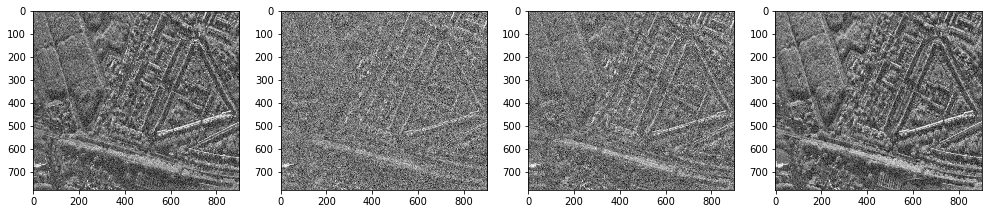

In [3]:
# Visualize 4 individual bands of the SAR test image
rcParams['figure.figsize'] = 17, 10
fig1, ax1 = plt.subplots(1, 4)
fp1 = 'test_public/AOI_11_Rotterdam/SN6_Test_Public_AOI_11_Rotterdam_SAR-Intensity_20190804111851_20190804112030_tile_5180.tif'
src1 = rasterio.open(fp1)

for i in range(1, 5):
    img = src1.read(i)
    img = img[:780] # Crop
    img = stretch(img)
    img = lee_filter(img, FILTSIZE)
    ax1[i-1].imshow(img, 'gray')
    
plt.show()

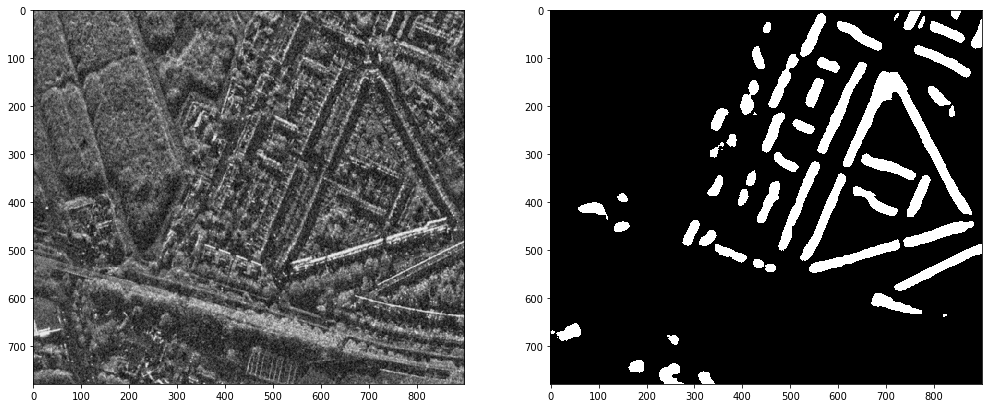

In [4]:
fig2, ax2 = plt.subplots(1, 2)

# Visualize SAR test image
img1 = np.dstack((src1.read(1), src1.read(2), src1.read(3), src1.read(4))) # Stack all bands into 3-D array
img1 = span_image(img1) # Reduce 4 bands into 1 band
img1 = img1[:780] # Crop
img1 = stretch(img1)
img1 = lee_filter(img1, FILTSIZE)

ax2[0].imshow(img1, 'gray')

# Visualize building footprint mask
fp2 = 'inference_continuous/SN6_Test_Public_AOI_11_Rotterdam_SAR-Intensity_20190804111851_20190804112030_tile_5180.tif'
src2 = rasterio.open(fp2)
img2 = src2.read(1)[:780] # Crop
# Convert to binary
img2[img2 < 0] = 0
img2[img2 > 0] = 1
ax2[1].imshow(img2, 'gray')

plt.show()